In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.stats.api as sms
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Functions for Linear Regression

In [2]:
# Create function to fit, make predictions and output results of linear regression
def fit_linear_reg(X_train, y_train, X_test, y_test):
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    print('R2 Score:',metrics.r2_score(y_train, y_hat_train))
    print('RMSE Train:',np.sqrt(metrics.mean_squared_error(y_train, y_hat_train)))
    print('RMSE Test:',np.sqrt(metrics.mean_squared_error(y_test, y_hat_test)))
    X_int = sm.add_constant(X_train)
    model = sm.OLS(y_train, X_int).fit()
    return model.summary()

# Regression on Airbnb Price (Current Listings)

In [3]:
airbnb_data = pd.read_csv('cleaned_data/current_listing_availability.csv', index_col=0)

airbnb_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6137 entries, 0 to 6136
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   last_scraped                      6137 non-null   object 
 1   id                                6137 non-null   int64  
 2   host_id                           6137 non-null   int64  
 3   host_is_superhost                 6137 non-null   int64  
 4   zipcode                           6137 non-null   float64
 5   latitude                          6137 non-null   float64
 6   longitude                         6137 non-null   float64
 7   accommodates                      6137 non-null   int64  
 8   bathrooms                         6137 non-null   float64
 9   beds                              6137 non-null   float64
 10  price                             6137 non-null   float64
 11  minimum_nights                    6137 non-null   float64
 12  maximu

## Prepare Data for Modeling

In [4]:
# need to drop columns that are highly correlated

airbnb_data.drop(columns=['zipcode','latitude','longitude','availability_30','availability_60',
                          'availability_90','number_of_reviews','review_scores_accuracy',
                          'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                          'review_scores_location','review_scores_value',
                          'calculated_host_listings_count','occ_rate','monthly_income'],inplace=True)

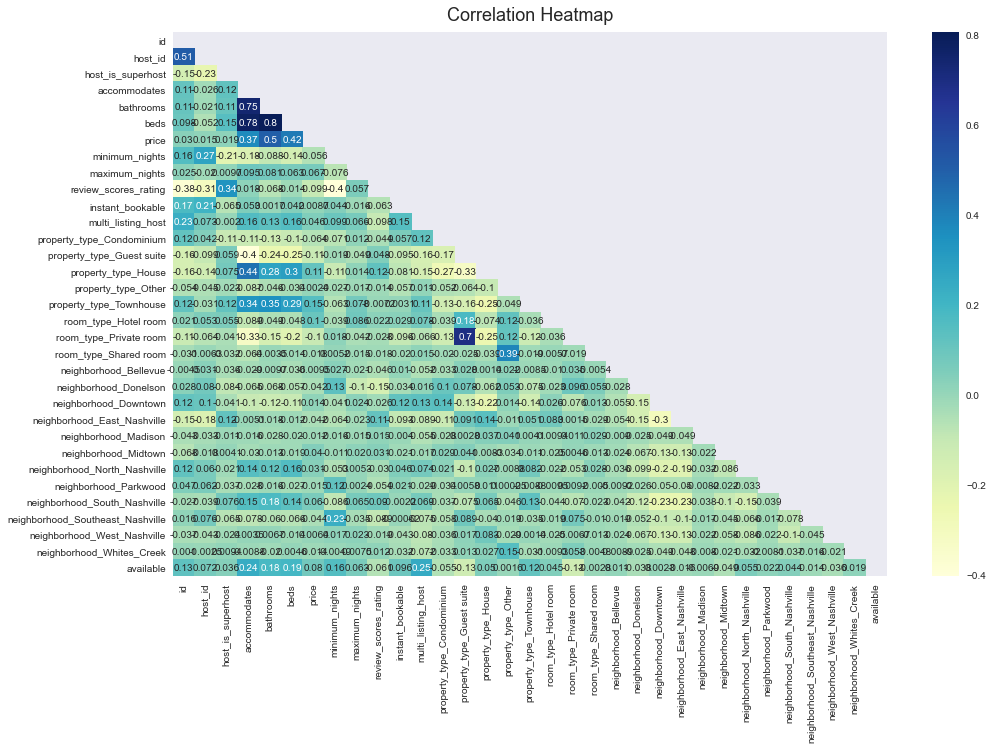

In [5]:
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(airbnb_data.corr(), dtype=np.bool))
heatmap = sns.heatmap(airbnb_data.corr(), mask=mask, cmap='YlGnBu', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

There appears to be very little correlation among different features.

In [6]:
airbnb_data

,last_scraped,id,host_id,host_is_superhost,accommodates,bathrooms,beds,price,minimum_nights,maximum_nights,...,neighborhood_East_Nashville,neighborhood_Madison,neighborhood_Midtown,neighborhood_North_Nashville,neighborhood_Parkwood,neighborhood_South_Nashville,neighborhood_Southeast_Nashville,neighborhood_West_Nashville,neighborhood_Whites_Creek,available
0,2021-02-20,6422,12172,1,2,1.0,3.0,40.0,30.0,365.0,...,1,0,0,0,0,0,0,0,0,217
1,2021-02-20,25613,95811,1,2,1.0,1.0,75.0,2.0,30.0,...,1,0,0,0,0,0,0,0,0,21
2,2021-02-20,136015,666322,0,2,1.0,1.0,103.0,30.0,1125.0,...,0,0,0,0,0,0,0,0,0,140
3,2021-02-20,258817,22296,1,2,1.0,2.0,27.0,30.0,365.0,...,0,0,0,0,0,0,0,0,0,314
4,2021-02-20,289242,22296,1,1,1.0,3.0,24.0,30.0,365.0,...,0,0,0,0,0,0,0,0,0,314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6132,2021-02-20,48207668,368944610,0,5,1.0,2.0,148.0,90.0,365.0,...,0,0,0,0,0,0,0,0,0,247
6133,2021-02-21,48208643,359230893,0,5,2.0,2.0,139.0,30.0,365.0,...,0,0,0,1,0,0,0,0,0,233
6134,2021-02-20,48211893,153902467,0,2,2.0,2.0,48.0,30.0,90.0,...,0,0,0,0,0,0,0,1,0,95
6135,2021-02-20,48224293,368944610,0,3,1.0,1.0,121.0,90.0,365.0,...,0,0,0,0,0,0,0,0,0,249


In [7]:
# set up variables and drop non numerical columns
y = airbnb_data['price']
X = airbnb_data.drop(['last_scraped', 'id','host_id','price'], axis=1)

In [8]:
# perform train-test split using a test size of 20%.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Run Baseline Model

In [9]:
fit_linear_reg(X_train, y_train, X_test, y_test)

R2 Score: 0.3100420933855327
RMSE Train: 262.27236360908046
RMSE Test: 343.7351737300438


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     73.07
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:06:14   Log-Likelihood:                -34306.
No. Observations:                4909   AIC:                         6.867e+04
Df Residuals:                    4878   BIC:                         6.887e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               16.6191     29.126      0.571      0.568     -40.481      73.719
host_is_superhost                  -15.0358      8.403     -1.789      0.074     -31.510       1.438
accommodates                         1.6415      2.084      0.788      0.431      -2.444       5.727
bathrooms                          109.6271      4.913     22.314      0.000      99.996     119.259
beds                                 6.0775      1.988      3.058      0.002       2.181       9.974
minimum_nights                      -0.5216      0.265     -1.970      0.049      -1.041      -0.003
maximum_nights                       0.0115      0.008      1.497      0.134      -0.004       0.027
review_scores_rating                -0.5957      0.125     -4.774      0.000      -0.840      -0.351
instant_bookable                    -0.4497      7.906     -0.057      0.955     -15.949      15.050
multi_listing_host                 -30.0480      8.826     -3.405      0.001     -47.351     -12.745
property_type_Condominium          -25.0990     13.590     -1.847      0.065     -51.742       1.544
property_type_Guest suite            5.1889     17.810      0.291      0.771     -29.726      40.104
property_type_House                -36.5719     13.136     -2.784      0.005     -62.324     -10.820
property_type_Other                 84.7764     32.199      2.633      0.008      21.652     147.900
property_type_Townhouse            -48.4434     16.876     -2.871      0.004     -81.527     -15.360
room_type_Hotel room               302.8351     40.092      7.553      0.000     224.236     381.434
room_type_Private room             -36.7218     18.745     -1.959      0.050     -73.471       0.027
room_type_Shared room             -154.7600     73.105     -2.117      0.034    -298.078     -11.442
neighborhood_Bellevue               23.0417     43.337      0.532      0.595     -61.918     108.001
neighborhood_Donelson               28.4430     27.001      1.053      0.292     -24.491      81.377
neighborhood_Downtown               84.7630     24.922      3.401      0.001      35.904     133.622
neighborhood_East_Nashville         28.1745     24.284      1.160      0.246     -19.434      75.783
neighborhood_Madison                63.9097     46.658      1.370      0.171     -27.561     155.380
neighborhood_Midtown               121.0538     28.102      4.308      0.000      65.962     176.146
neighborhood_North_Nashville        11.7945     25.982      0.454      0.650     -39.141      62.730
neighborhood_Parkwood               27.6084     45.659      0.605      0.545     -61.904     117.121
neighborhood_South_Nashville        34.3241     25.210      1.362      0.173     -15.099      83.748
neighborhood_Southeast_Nashville    21.7777     31.31

Using all of the features, we obtain an R2 value of .31. Our train and test RMSE values are relatively close to each other, but still very high. Let's remove any statistically insignificant features using stepwise selection.

## Choose Model Features Using Stepwise Selection

In [10]:
y = airbnb_data['price']
X = airbnb_data.drop(['last_scraped', 'id','host_id','price'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [12]:
new_x_cols = stepwise_selection(X_train, y_train, verbose=True)
print('resulting features:')
print(new_x_cols)

<ipython-input-11-3a06d07146b7>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)


Add  bathrooms                      with p-value 0.0
Add  room_type_Hotel room           with p-value 2.14691e-17
Add  neighborhood_Downtown          with p-value 1.5739e-10
Add  neighborhood_Midtown           with p-value 3.70025e-08
Add  review_scores_rating           with p-value 1.74404e-06
Add  multi_listing_host             with p-value 0.000169009
Add  beds                           with p-value 0.000365931
resulting features:
['bathrooms', 'room_type_Hotel room', 'neighborhood_Downtown', 'neighborhood_Midtown', 'review_scores_rating', 'multi_listing_host', 'beds']


In [13]:
X_train = X_train[new_x_cols]
X_test = X_test[new_x_cols]

In [14]:
fit_linear_reg(X_train, y_train, X_test, y_test)

R2 Score: 0.30379237131377246
RMSE Train: 263.45753318439114
RMSE Test: 343.2087626100436


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     305.5
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        17:06:16   Log-Likelihood:                -34328.
No. Observations:                4909   AIC:                         6.867e+04
Df Residuals:                    4901   BIC:                         6.872e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    17.3249     12.485      1.388      0.165      -7.151      41.801
bathrooms               106.5413      4.537     23.482      0.000      97.646     115.436
room_type_Hotel room    335.7683     36.977      9.081      0.000     263.277     408.259
neighborhood_Downtown    69.7428      9.161      7.613      0.000      51.784      87.702
neighborhood_Midtown     96.2691     16.758      5.745      0.000      63.417     129.121
review_scores_rating     -0.5723      0.107     -5.343      0.000      -0.782      -0.362
multi_listing_host      -33.0787      8.096     -4.086      0.000     -48.950     -17.207
beds                      6.3050      1.768      3.566      0.000       2.839       9.771
==============================================================================
Omnibus:                    11196.419   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        105454386.224
Skew:                          21.553   Prob(JB):                         0.00
Kurtosis:                     719.733   Cond. No.                         873.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can only achieve a .30 R2 score using statistically significant airbnb qualities to predict price. We conclude we cannot predict price with confidence using this model.

# Regression on Average Home Value

In [15]:
regression_df = pd.read_csv("cleaned_data/model_data_clean.csv", index_col=0)

regression_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69 entries, 2015-06-01 to 2021-02-01
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                39 non-null     float64
 1   host_id                           39 non-null     float64
 2   zipcode                           39 non-null     float64
 3   latitude                          39 non-null     float64
 4   longitude                         39 non-null     float64
 5   accommodates                      39 non-null     float64
 6   bathrooms                         39 non-null     float64
 7   beds                              39 non-null     float64
 8   price                             39 non-null     float64
 9   minimum_nights                    39 non-null     float64
 10  maximum_nights                    39 non-null     float64
 11  availability_30                   39 non-null     float64
 12

In [16]:
regression_df.head()

,id,host_id,zipcode,latitude,longitude,accommodates,bathrooms,beds,price,minimum_nights,...,property_type_Condominium,property_type_Guest suite,property_type_House,property_type_Other,property_type_Townhouse,room_type_Hotel room,room_type_Private room,room_type_Shared room,inventory,avg_home_value
2015-06-01,4.911123e+06,1.847859e+07,37202.099174,36.161913,-86.768430,4.223140,1.450413,2.033058,163.115702,1.545455,...,1.0,0.0,78.0,6.0,1.0,0.0,39.0,3.0,121,198388.0
2015-07-01,4.585624e+06,1.588542e+07,37202.203096,36.157222,-86.767316,4.607430,1.500310,2.308978,202.349226,1.698452,...,33.0,0.0,1049.0,59.0,18.0,0.0,451.0,18.0,1615,199865.0
2015-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,201227.0
2015-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,202952.0
2015-10-01,5.435875e+06,1.857827e+07,37201.418483,36.156564,-86.767390,4.795735,1.528910,2.406161,200.524171,1.747867,...,54.0,0.0,1370.0,72.0,51.0,0.0,566.0,30.0,2110,204617.0


In [17]:
regression_df.tail()

,id,host_id,zipcode,latitude,longitude,accommodates,bathrooms,beds,price,minimum_nights,...,property_type_Condominium,property_type_Guest suite,property_type_House,property_type_Other,property_type_Townhouse,room_type_Hotel room,room_type_Private room,room_type_Shared room,inventory,avg_home_value
2020-10-01,2.947930e+07,1.089430e+08,37202.054170,36.161081,-86.769555,6.279273,1.918002,3.715442,212.609249,5.055161,...,747.0,1078.0,2121.0,124.0,629.0,73.0,681.0,16.0,6055,298809.0
2020-11-01,2.973666e+07,1.117253e+08,37202.339950,36.160847,-86.770116,6.231287,1.910765,3.692683,211.482086,5.151051,...,749.0,1052.0,2059.0,129.0,604.0,74.0,652.0,18.0,5945,301461.0
2020-12-01,3.052512e+07,1.180080e+08,37202.158459,36.160308,-86.769276,6.198440,1.911263,3.645701,212.335529,7.567203,...,747.0,1053.0,2067.0,123.0,650.0,73.0,650.0,16.0,6153,304539.0
2021-01-01,3.075861e+07,1.189783e+08,37201.963630,36.160229,-86.769186,6.204292,1.912762,3.651048,195.307339,7.314056,...,748.0,1050.0,2061.0,121.0,645.0,76.0,640.0,17.0,6104,307585.0
2021-02-01,3.121712e+07,1.218997e+08,37202.099397,36.160393,-86.768885,6.234968,1.926104,3.667916,204.767965,7.553854,...,756.0,1056.0,2073.0,118.0,665.0,66.0,652.0,18.0,6137,310812.0


## Prepare Data for Modeling

In [18]:
# drop any rows with missing data for a month
regression_df.dropna(inplace=True)

regression_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39 entries, 2015-06-01 to 2021-02-01
Data columns (total 50 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                39 non-null     float64
 1   host_id                           39 non-null     float64
 2   zipcode                           39 non-null     float64
 3   latitude                          39 non-null     float64
 4   longitude                         39 non-null     float64
 5   accommodates                      39 non-null     float64
 6   bathrooms                         39 non-null     float64
 7   beds                              39 non-null     float64
 8   price                             39 non-null     float64
 9   minimum_nights                    39 non-null     float64
 10  maximum_nights                    39 non-null     float64
 11  availability_30                   39 non-null     float64
 12

In [19]:
# drop columns that could be calculated by using other columns--too much similarity
regression_df.drop(columns=['zipcode','latitude','longitude','availability_30','availability_60',
                          'availability_90','review_scores_accuracy',
                          'review_scores_cleanliness','review_scores_checkin','review_scores_communication',
                          'review_scores_location','review_scores_value','calculated_host_listings_count',
                            'occ_rate','monthly_income'],inplace=True)

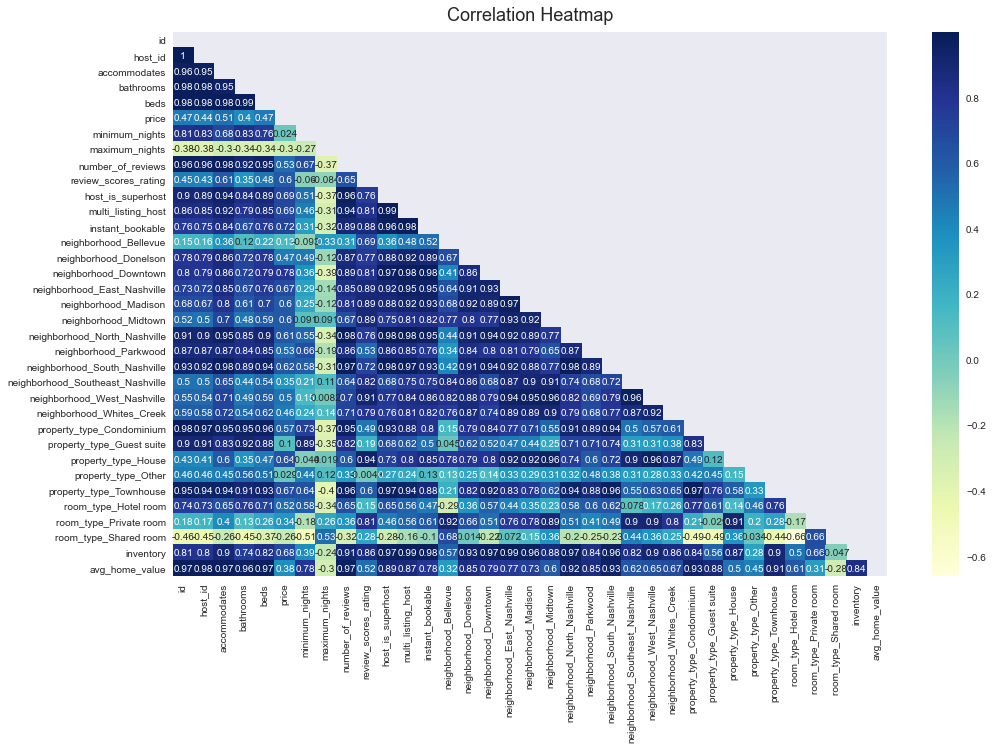

In [20]:
# review correlation between the remaining columns
plt.figure(figsize=(16, 10))
mask = np.triu(np.ones_like(regression_df.corr(), dtype=np.bool))
heatmap = sns.heatmap(regression_df.corr(), mask=mask, cmap='YlGnBu', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=12);

There are clearly many features correlated with each other in the data.

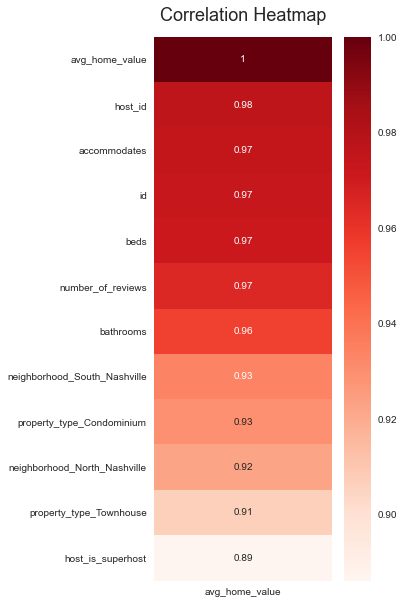

In [21]:
plt.figure(figsize=(4, 10))
#mask = np.triu(np.ones_like(regression_df.corr(), dtype=np.bool))
heatmap = sns.heatmap(regression_df.corr()[['avg_home_value']].sort_values(by='avg_home_value', ascending=False)[:12],
                       cmap='Reds', annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':18}, pad=16)
plt.savefig('images/corr_heatmap.png');

Let's run a baseline simple regression model using just 'accommodates' which is highly correlated with average home value. 

## Run Baseline Model

In [22]:
y = regression_df['avg_home_value']
X = regression_df[['accommodates']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

fit_linear_reg(X_train, y_train, X_test, y_test)

R2 Score: 0.9504792618760186
RMSE Train: 6300.0169425470385
RMSE Test: 3877.9812105253045


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         avg_home_value   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     556.6
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           1.79e-20
Time:                        17:06:22   Log-Likelihood:                -315.18
No. Observations:                  31   AIC:                             634.4
Df Residuals:                      29   BIC:                             637.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -5.123e+04   1.37e+04     -3.740      0.001   -7.92e+04   -2.32e+04
accommodates  5.559e+04   2356.298     23.593      0.000    5.08e+04    6.04e+04
==============================================================================
Omnibus:                        7.925   Durbin-Watson:                   1.336
Prob(Omnibus):                  0.019   Jarque-Bera (JB):                6.371
Skew:                           1.042   Prob(JB):                       0.0414
Kurtosis:                       3.765   Cond. No.                         70.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

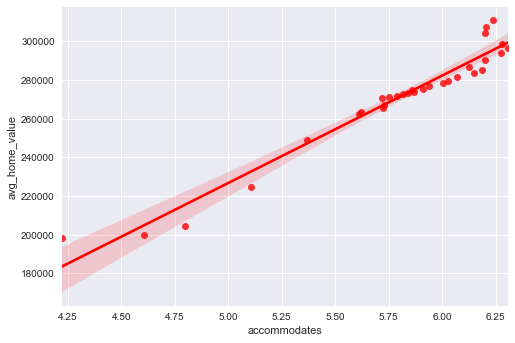

In [23]:
sns.regplot(x=X_train,y=y_train, color='r');

We achieve an R2 value of .95 using just the average number of people an Airbnb accommodates. Our test error is also lower than the train error, meaning the model is not overfit.

## PCA

There is too much multicollinearity present to use all of our features. Let's see if using PCA will help combat multicollinearity and improve our model.

In [24]:
y = regression_df['avg_home_value']
X = regression_df.drop(['host_id','id','avg_home_value'], axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

In [26]:
# to use PCA have to scale features first
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [27]:
pca = PCA(n_components=3)

pc_train = pca.fit_transform(X_train)
pc_test = pca.transform(X_test)

In [28]:
fit_linear_reg(pc_train, y_train, pc_test, y_test)

R2 Score: 0.9071204139834635
RMSE Train: 8627.963480666544
RMSE Test: 6848.13077869691


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         avg_home_value   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     87.90
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           4.75e-14
Time:                        17:06:22   Log-Likelihood:                -324.93
No. Observations:                  31   AIC:                             657.9
Df Residuals:                      27   BIC:                             663.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.707e+05   1660.452    163.043      0.000    2.67e+05    2.74e+05
x1            -0.0605      0.011     -5.341      0.000      -0.084      -0.037
x2            -7.8780      0.577    -13.643      0.000      -9.063      -6.693
x3            23.1759      3.309      7.004      0.000      16.386      29.966
==============================================================================
Omnibus:                        6.768   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                2.016
Skew:                           0.016   Prob(JB):                        0.365
Kurtosis:                       1.751   Cond. No.                     1.47e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Using PCA with 3 components, we are able to get an R2 value of 0.91. It appears we are still better off using the simple linear regression model.

In [29]:
print(abs( pca.components_ ))

[[9.70464021e-07 2.59061495e-07 8.81271377e-07 7.86325145e-05
  2.87658786e-06 9.99980383e-01 2.88828822e-05 1.87404136e-06
  2.89501646e-03 2.67617731e-03 3.43750089e-03 2.20728905e-05
  1.28236207e-04 1.40972411e-03 3.42183054e-04 1.21438820e-05
  6.19419253e-05 4.84479804e-04 9.18088886e-06 5.12471020e-04
  3.32337721e-05 3.41584187e-06 8.17238870e-06 5.26123653e-04
  8.18335547e-04 8.88851401e-05 6.09300730e-05 5.61744280e-04
  7.24609747e-05 3.26560382e-04 4.31015648e-05 2.80280764e-03]
 [1.49332387e-04 3.05026383e-05 1.14349631e-04 1.07399167e-02
  1.94157513e-04 5.88267097e-03 3.36597958e-03 8.43423952e-04
  3.75416385e-01 4.14096769e-01 4.67608377e-01 4.00391472e-03
  3.41480787e-02 1.67054651e-01 1.28060303e-01 5.15748467e-03
  2.98251284e-02 6.71736828e-02 3.42299691e-03 8.00826371e-02
  1.45382956e-02 3.10907808e-02 4.44800256e-03 6.42087864e-02
  5.86405219e-02 2.27293164e-01 3.91496195e-03 6.21935960e-02
  6.35005208e-03 5.26380304e-02 3.82497079e-04 5.86778057e-01]
 [3.28

In [30]:
pca_data = pd.DataFrame(abs(pca.components_))
pca_data.columns = X_train.columns
pca_data = pca_data.T
pca_data

,0,1,2
accommodates,9.704640e-07,0.000149,0.000329
bathrooms,2.590615e-07,0.000031,0.000141
beds,8.812714e-07,0.000114,0.000375
price,7.863251e-05,0.010740,0.015770
minimum_nights,2.876588e-06,0.000194,0.002381
maximum_nights,9.999804e-01,0.005883,0.001609
number_of_reviews,2.888288e-05,0.003366,0.007269
review_scores_rating,1.874041e-06,0.000843,0.002223
host_is_superhost,2.895016e-03,0.375416,0.398670
multi_listing_host,2.676177e-03,0.414097,0.194395


In [31]:
print(pca_data[0].idxmax())
print(pca_data[1].idxmax())
print(pca_data[2].idxmax())

maximum_nights
inventory
property_type_House


maximum_nights, inventory, and property_type_House contributed most to the principal components.

## Chose Model Features Using Stepwise Selection

Although we were able to get pretty strong scores using just the accommodates number, let's see if we can improve our results at all by adding features through stepwise selection.

In [32]:
new_x_cols = stepwise_selection(X_train, y_train, verbose=True)
print('resulting features:')
print(new_x_cols)

Add  beds                           with p-value 1.3276e-20

<ipython-input-11-3a06d07146b7>:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_pval = pd.Series(index=excluded)



Add  number_of_reviews              with p-value 0.00137295
Add  price                          with p-value 8.1436e-05
resulting features:
['beds', 'number_of_reviews', 'price']


In [33]:
X_train = X_train[new_x_cols]
X_test = X_test[new_x_cols]

In [34]:
fit_linear_reg(X_train, y_train, X_test, y_test)

R2 Score: 0.9813724312228115
RMSE Train: 3863.903313329694
RMSE Test: 2837.981898810875


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         avg_home_value   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     474.2
Date:                Tue, 13 Apr 2021   Prob (F-statistic):           1.87e-23
Time:                        17:06:23   Log-Likelihood:                -300.03
No. Observations:                  31   AIC:                             608.1
Df Residuals:                      27   BIC:                             613.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               1.19e+05   1.16e+04     10.288      0.000    9.53e+04    1.43e+05
beds               3.394e+04   6411.598      5.293      0.000    2.08e+04    4.71e+04
number_of_reviews  1422.5409    243.673      5.838      0.000     922.565    1922.517
price               -86.4629     18.658     -4.634      0.000    -124.746     -48.179
==============================================================================
Omnibus:                        0.326   Durbin-Watson:                   1.432
Prob(Omnibus):                  0.849   Jarque-Bera (JB):                0.185
Skew:                          -0.178   Prob(JB):                        0.912
Kurtosis:                       2.873   Cond. No.                     4.39e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We were able to get an even better R2 score of .98 and a better test RMSE of 2,837. This means our model can explain 98% of the variance in average home value within an error of $2.8k. We will proceed with this model as our final model.

### Perform Cross-Validation

In [35]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [36]:
X = X[new_x_cols]
mse = make_scorer(mean_squared_error)

cv_20_results = cross_val_score(model, X, y, cv=20, scoring=mse)
cv_20_results
np.mean(np.sqrt(cv_20_results))

4092.686184875137

### Check for Assumptions of Linear Regression

In [37]:
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()

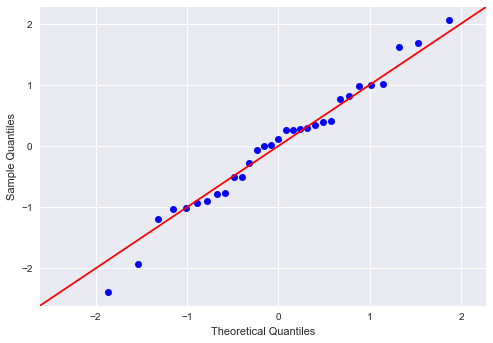

In [38]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

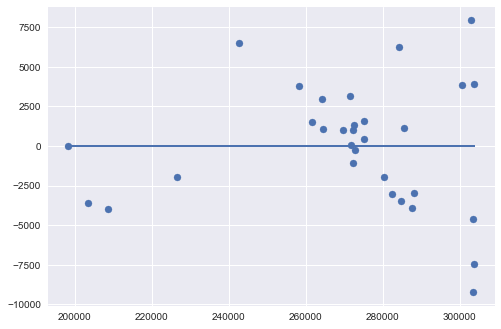

In [39]:
plt.scatter(model.predict(X_int), model.resid)
plt.plot(model.predict(X_int), [0 for i in range(len(X_int))]);

It looks like our assumptions of linear regression hold up for the most part.

## Visualize Model Results

In [40]:
feature_cols = list(X_train.columns)

y = regression_df['avg_home_value']
X = regression_df[feature_cols]
final_reg_features_df = pd.concat([y,X], axis=1)

final_reg_features_df.head()

,avg_home_value,beds,number_of_reviews,price
2015-06-01,198388.0,2.033058,17.206612,163.115702
2015-07-01,199865.0,2.308978,16.536223,202.349226
2015-10-01,204617.0,2.406161,17.715640,200.524171
2016-09-01,224658.0,2.602991,25.443699,196.314922
2017-09-01,249172.0,2.836834,31.943173,209.013691


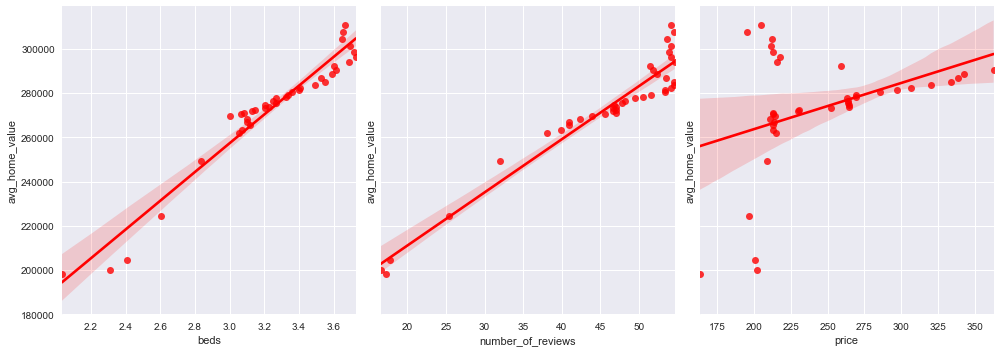

In [41]:
f, axes = plt.subplots(1, 3, figsize=(14, 5), sharey=True)
sns.despine(left=True)

sns.regplot(x='beds', y='avg_home_value', data=final_reg_features_df, ax= axes[0], color='r')
sns.regplot(x='number_of_reviews', y='avg_home_value', data=final_reg_features_df, ax= axes[1],color='r')
sns.regplot(x='price', y='avg_home_value', data=final_reg_features_df, ax= axes[2],color='r')

# plt.setp(axes, yticks=[])
plt.tight_layout()
plt.savefig('images/reg_subplots.png')

In [42]:
model_final = LinearRegression()
model_final.fit(X_train, y_train)
y_hat_train = model_final.predict(X_train)
y_hat_test = model_final.predict(X_test)
metrics.r2_score(y_train, y_hat_train)

0.9813724312228115

In [43]:
coeff_df = pd.DataFrame(model_final.coef_, X_train.columns, columns = ['Coeff'])

coeff_df

,Coeff
beds,33939.407282
number_of_reviews,1422.540881
price,-86.462897


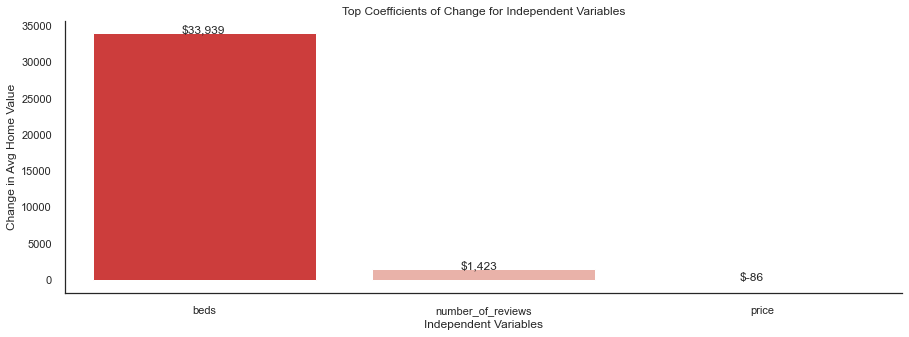

In [47]:
colors = ['#E42524', '#F4AA9E', '#008D8A', '#E3F9F7']

sns.set_palette(sns.color_palette(colors))
sns.set_context('notebook')
sns.set_style('white')

plt.figure(figsize=(15,5))
ax = sns.barplot(x = coeff_df.index, y = coeff_df['Coeff'], 
            data=coeff_df)
ax.set_title('Top Coefficients of Change for Independent Variables')
ax.set(xlabel='Independent Variables', ylabel= 'Change in Avg Home Value')

for p in ax.patches:
    height = p.get_height() 
    width = p.get_width() 
    ax.text(x = p.get_x()+(width/2.5),
            y = height+.25,
            s = '${:,.0f}'.format(height)) 

sns.despine()
plt.savefig('images/reg_coefs.png')

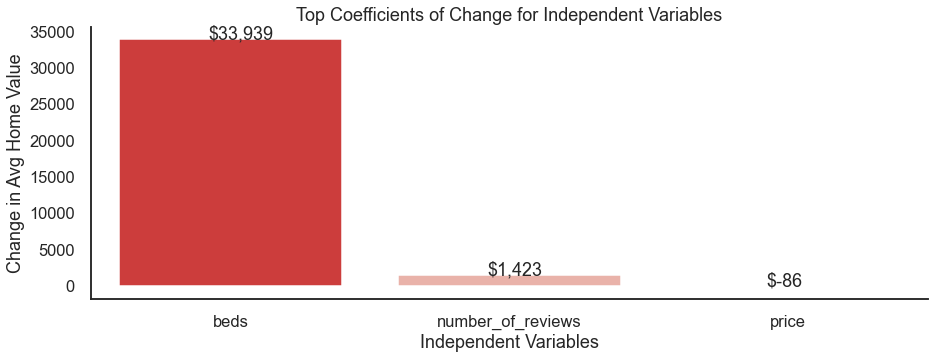

In [48]:
colors = ['#E42524', '#F4AA9E', '#008D8A', '#E3F9F7']

sns.set_palette(sns.color_palette(colors))
sns.set_context('talk')
sns.set_style('white')

plt.figure(figsize=(15,5))
ax = sns.barplot(x = coeff_df.index, y = coeff_df['Coeff'], 
            data=coeff_df)
ax.set_title('Top Coefficients of Change for Independent Variables')
ax.set(xlabel='Independent Variables', ylabel= 'Change in Avg Home Value')

for p in ax.patches:
    height = p.get_height() 
    width = p.get_width() 
    ax.text(x = p.get_x()+(width/2.5),
            y = height+.25,
            s = '${:,.0f}'.format(height)) 

sns.despine()

In [45]:
final_reg_features_df.to_csv("cleaned_data/final_reg_features.csv")